In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
np.set_printoptions(suppress=True)


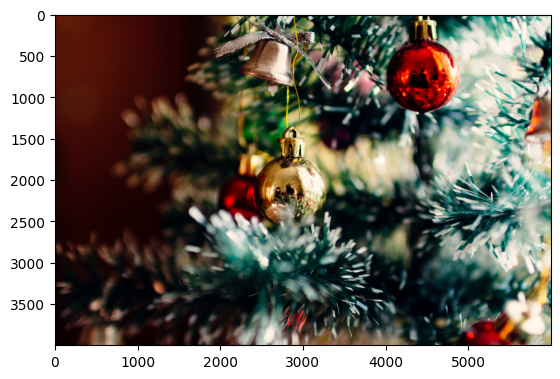

In [73]:
image_path = "images/rodion-kutsaiev-ySNkCkdKyTY-unsplash-small.png"
# image_path = "images/rodion-kutsaiev-ySNkCkdKyTY-unsplash.png"
image = plt.imread(image_path)

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")

# Step 1 
## Colorspace Transformation

In [74]:
def rgb_to_yuv(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    y,u,v = cv2.split(yuv)
    return y*255,u*255,v*255

In [75]:
y,u,v = rgb_to_yuv(image=image)

In [76]:
def plot_y_u_v(y,u,v):
    fig, ax = plt.subplots(1,3, figsize=(15,20))
    # ax[0].title("Y Component")
    ax[0].imshow(y, cmap="gray")
    ax[0].set_title("Y Component")
    ax[1].imshow(u, cmap="gray")
    ax[1].set_title("U Component")
    ax[2].imshow(v, cmap="gray")
    ax[2].set_title("V Component")
    plt.show()


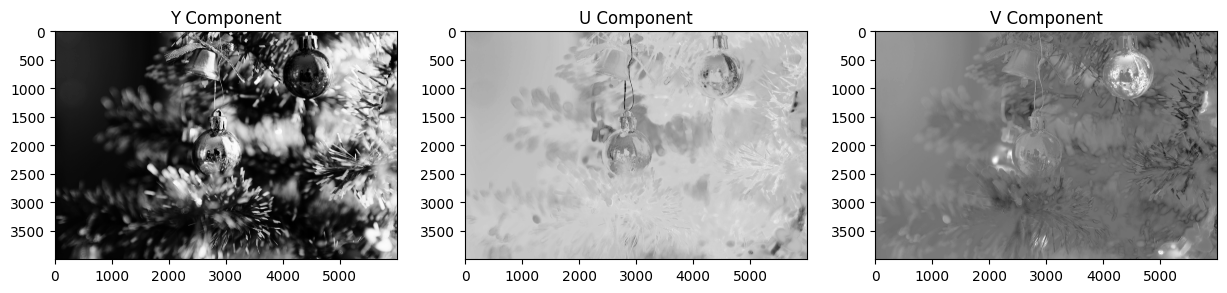

In [77]:
plot_y_u_v(y,u,v)


# Step 2 
## Subsampling of Color Components

In [78]:
def subsample_u_v(u, v, j, a, b):
    """
    subsamples the y u v components based on the ratio given by j a b
    j is the sampling reference width
        each block that is subsampled is of size j * 2
    a is the number of samples in the first row
    b is the number of samples in the second row equal to a or 0
    """
    if j != 4 or a not in [4, 2, 1] or b not in [a, 0]:
        raise RuntimeError("Invalid value for subsampling settings")
    if j == 4 and a == 4 and b == 4 :
        return u,v 
    if int(j/a) != j/a:
        raise RuntimeError("Invalid value for subsampling settings")

    if b == 0:
        return u[::2, ::int(j/a)], v[::2, ::int(j/a)]
    else:
        return u[::1, ::int(j/a)], v[::1, ::int(j/a)]
   

In [79]:
size = 8
matr = []
for i in range(size):
    matr.append(np.array(range(i*size, (i+1)*size)))
matr = np.array(matr)
print(matr)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [80]:
u_subs, v_subs = subsample_u_v(u,v, 4,2,0)


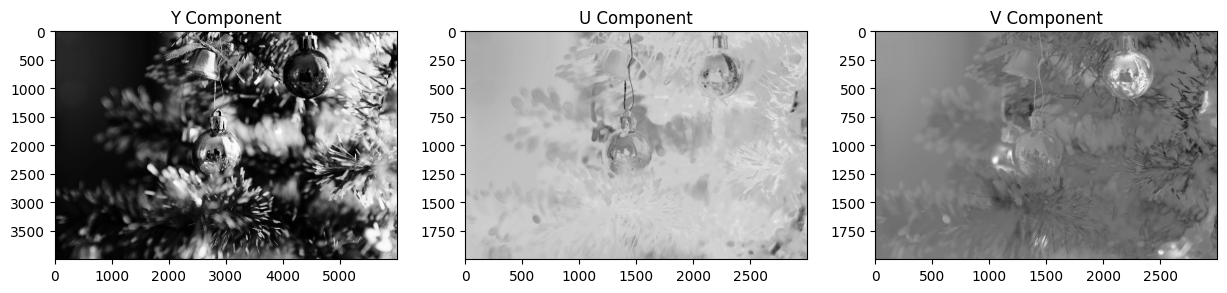

In [81]:
plot_y_u_v(y,u_subs,v_subs)


# Step 3
## Split into 8x8 Blocks

In [82]:
def resize_to_blocksize(color_component_in, block_size):
    remainder_y = block_size - color_component_in.shape[0] % block_size
    remainder_x = block_size - color_component_in.shape[1] % block_size

    if remainder_x == block_size:
        remainder_x = 0
    if remainder_y == block_size:
        remainder_y = 0

    color_component = []

    for line in color_component_in:
        extended_line = line.copy()
        extended_line.resize(len(line) + remainder_x)
        color_component.append(extended_line)
    color_component = np.array(color_component)

    color_component.resize(len(color_component) + remainder_y, len(color_component[0]))

    return color_component

def split(color_component_in, block_size=8):

    color_component = resize_to_blocksize(color_component_in, block_size)
    blocks = []
    for block_y in range(color_component.shape[0] // block_size):
        for block_x in range(color_component.shape[1] // block_size):
            block_start_y = block_y * block_size
            block_end_y = block_y * block_size + block_size

            block_start_x = block_x * block_size
            block_end_x = block_x * block_size + block_size

            block = np.array([row[block_start_x:block_end_x] for row in color_component[block_start_y:block_end_y]])
            blocks.append(block)
#    blocks = np.array(blocks)
    return blocks



In [83]:
block_size = 8

split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)


## Step 3
### create dct matrix

In [84]:
def basis_vector(N,k) :
    n = np.arange(0, N)
    if k == 0:
        ck = np.sqrt(1/N)
    else:
        ck = np.sqrt(2/N)

    ak_n = ck*np.cos((np.pi/(2*N))*k*(2*n+1))
    return ak_n

def dct_mat(N):
    res = []
    for k in range(N):
        res.append(basis_vector(N,k))
    return np.array(res)

def block_dct2(blocks, block_size):
    transformed = []
    transformation_mat = dct_mat(block_size)

    for block in blocks:
        transformed.append(np.matmul(np.matmul(transformation_mat, block), transformation_mat.transpose()))

    transformed = np.array(transformed)

    return transformed

In [85]:
# https://www.math.cuhk.edu.hk/~lmlui/dct.pdf
data_list = [26, -5, -5, -5, -5, -5, -5, 8,
             64, 52, 8, 26, 26, 26, 8, -18,
             126, 70, 26, 26, 52, 26, -5, -5,
             111, 52, 8, 52, 52, 38, -5, -5,
             52, 26, 8, 39, 38, 21, 8, 8,
             0, 8, -5, 8, 26, 52, 70, 26,
             -5, -23, -18, 21, 8, 8, 52, 38,
             -18, 8, -5, -5, -5, 8, 26, 8]
matrix = np.array(data_list).reshape(8, 8)


print(np.matrix(np.round(dct_mat(8), 4))) #dct matrix is correct

b = block_dct2([matrix], block_size) #block transform is also correct
print(b)


[[ 0.3536  0.3536  0.3536  0.3536  0.3536  0.3536  0.3536  0.3536]
 [ 0.4904  0.4157  0.2778  0.0975 -0.0975 -0.2778 -0.4157 -0.4904]
 [ 0.4619  0.1913 -0.1913 -0.4619 -0.4619 -0.1913  0.1913  0.4619]
 [ 0.4157 -0.0975 -0.4904 -0.2778  0.2778  0.4904  0.0975 -0.4157]
 [ 0.3536 -0.3536 -0.3536  0.3536  0.3536 -0.3536 -0.3536  0.3536]
 [ 0.2778 -0.4904  0.0975  0.4157 -0.4157 -0.0975  0.4904 -0.2778]
 [ 0.1913 -0.4619  0.4619 -0.1913 -0.1913  0.4619 -0.4619  0.1913]
 [ 0.0975 -0.2778  0.4157 -0.4904  0.4904 -0.4157  0.2778 -0.0975]]
[[[162.25        40.59898161  20.00269181  72.32940087  30.25
    12.48483539 -19.65050433 -11.49714517]
  [ 30.47929369 108.41596982  10.4730992   32.29251751  27.69908851
   -15.50489247  18.4075948   -1.99566961]
  [-94.14450749 -60.05113291  12.29809704 -43.41889626 -31.28787023
     6.06690905  -3.33058262   7.14403453]
  [-38.5675018  -83.35751488  -5.41238759 -22.16986015 -13.5195286
    15.49189159  -1.33187181   3.53461026]
  [-31.25        17.934005

In [86]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)


## Step 3 
### Quantization


In [87]:
quantization_50_values = [
    16, 11, 10, 16, 24, 40, 51, 61,
    12, 12, 14, 19, 26, 58, 60, 55,
    14, 13, 16, 24, 40, 57, 69, 56,
    14, 17, 22, 29, 51, 87, 80, 62,
    18, 22, 37, 56, 68, 109, 103, 77,
    24, 35, 55, 64, 81, 104, 113, 92,
    49, 64, 78, 87, 103, 121, 120, 101,
    72, 92, 95, 98, 112, 100, 103, 99
]
quantization_50 = np.array(quantization_50_values).reshape(8, 8)

quantization_100 = np.zeros((8,8)) + 1

print(quantization_100)
# c = np.round(np.divide(b[0], quantization_50), 0)
# print(c)

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


In [88]:
def quantize(blocks, qunatization_table):
    quantized = []

    for block in blocks:
        quantized.append(np.round(np.divide(block, qunatization_table), 0))

    quantized = np.array(quantized)

    return quantized


In [89]:
quantized_y = quantize(trans_y, quantization_100)
quantized_u = quantize(trans_u, quantization_100)
quantized_v = quantize(trans_v, quantization_100)
#quantized_y = quantize(trans_y, quantization_50)
#quantized_u = quantize(trans_u, quantization_50)
#quantized_v = quantize(trans_v, quantization_50)

## Step 4 
### Encoding

In [91]:
def resort_values(block, block_size):
    new_block = []
    for diag in range(2 * block_size - 1):
        direction = diag % 2 == 0
        if diag < block_size:
            if direction:
                x = 0
                y = diag
            else:
                x = diag
                y = 0
        else:
            if direction:
                x = diag - block_size + 1
                y = block_size - 1
            else:
                x = block_size - 1
                y = diag - block_size + 1

        while x < block_size and y < block_size and x >= 0 and y >= 0:
            new_block.append(block[y][x])
            
            if(direction):
                x += 1
                y -=1
            else:
                x -=1
                y += 1

    return new_block



In [92]:
def run_length_encode(input_vals):
    encoded_list = []
    current = input_vals[0]
    current_counter = 1
    for i, val in enumerate(input_vals[1:]):
        if val == current:
            current_counter += 1
        else:
            encoded_list.append((current, current_counter))
            current = val
            current_counter = 1

    encoded_list.append((current, current_counter))

    return encoded_list
        

In [93]:
def flatten(encoded):
    res = []
    for val in encoded:
        res.append(val[0])
        res.append(val[1])
    return res


In [94]:
def encode(color_component, block_size):
    encoded_blocks = []
    for block in color_component:
        resorted = resort_values(block, block_size)
        run_length_encoded = run_length_encode(resorted)
        flattened = flatten(run_length_encoded)
        encoded_blocks += flattened
    return encoded_blocks

In [95]:
encoded_y = encode(quantized_y, block_size)
encoded_u = encode(quantized_u, block_size)
encoded_v = encode(quantized_v, block_size)


In [96]:
print(encoded_u[0])
print(encoded_v[0])

-141.0
348.0


In [97]:
class Node:
    def __init__(self, value, occurence, left = None, right = None):  
        self.value = value
        self.occurence = occurence
        self.left = left
        self.right = right

# https://www.javatpoint.com/huffman-coding-using-python

In [98]:
def traverse_tree(node, codes, current_code = ""):
    if(node.left):  
        traverse_tree(node.left, codes, current_code + "1")  
    if(node.right):  
        traverse_tree(node.right, codes, current_code + "0")  
  
    if(not node.left and not node.right):
        codes[node.value] = current_code
             

def generate_huffman_code(values):
    occurences = {}
    for val in values:
        if val in occurences:
            occurences[val] += 1
        else:
            occurences[val] = 1
    
#    print(len(occurences), occurences)

    nodes = [Node(val, occ) for val, occ in occurences.items()]

    while len(nodes) > 1:
        nodes = sorted(nodes, key = lambda x: x.occurence)  
        
        left = nodes[0]
        right = nodes[1]
        nodes.remove(left)
        nodes.remove(right)

        root_node = Node("", left.occurence + right.occurence, left, right)
        nodes.append(root_node)
    

    codes = {}
    traverse_tree(root_node, codes)

    return codes


In [99]:
def encode_huffman(huffman_code, message):
    encoded = ""
    for val in message:
        encoded += huffman_code[val]
    return encoded


In [100]:
data = encoded_y + encoded_u + encoded_v
huffman_code = generate_huffman_code(data)
encoded = encode_huffman(huffman_code, data)
print("original", len(data * 8), "bits")
print("encoded",len(encoded), "bits")
print("encoded + table",len(encoded) + len(huffman_code) * 16, "bits")
print("compression ratio", len(data * 8)/ len(encoded))

original 168333072 bits
encoded 77703853 bits
encoded + table 77738269 bits
compression ratio 2.166341378206818


In [101]:
import pickle
with open("compressed.jpegv2", "wb") as fp:
    pickle.dump((huffman_code, encoded), fp)



In [102]:
huffman_code_y = generate_huffman_code(encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, encoded_y)

huffman_code_u = generate_huffman_code(encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, encoded_u)

huffman_code_v = generate_huffman_code(encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, encoded_v)

print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded",len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
print("compression ratio", len(data * 8)/ (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 55983734 bits
u 7846895 bits
v 13349636 bits
encoded 77180265 bits
compression ratio 2.181037756219158
